In [1]:
!nvidia-smi

Thu Oct  5 15:45:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
|  0%   39C    P3   106W / 370W |    433MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd
from rich import print
import pathlib
from scipy import io as sio

from hvsrUNet.module.GPRNet import GPRNet
from hvsrUNet.toolbox.smooth import smooth

In [3]:
path_dir = pathlib.Path('../data/')
cv_list = sio.loadmat(path_dir/'cv_list.mat')['cv_list']
model_list = sio.loadmat(path_dir/'model_list_success.mat')['model_list_success']
fks = sio.loadmat(path_dir/'fks.mat')['fks']
fks = fks.reshape(-1)
hzcum = sio.loadmat(path_dir/'hzcum.mat')['hzcum']
hzcum = hzcum.reshape(-1)
print(f'cv_list.shape: {cv_list.shape}')
print(f'model_list.shape: {model_list.shape}')
print(f'fks.shape: {fks.shape}')
print(f'hzcum.shape: {hzcum.shape}')

disp = cv_list
Vs = model_list

cv_list.shape: (1200, 512)

model_list.shape: (1200, 512)

fks.shape: (512,)

hzcum.shape: (512,)

In [4]:
disp    = np.expand_dims(disp, axis=-1) / 1000.
Vs      = np.expand_dims(Vs, axis=-1) / 1000.

X_train, X_test, y_train, y_test = train_test_split(disp, Vs, test_size=0.2)#, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)#, random_state=42)

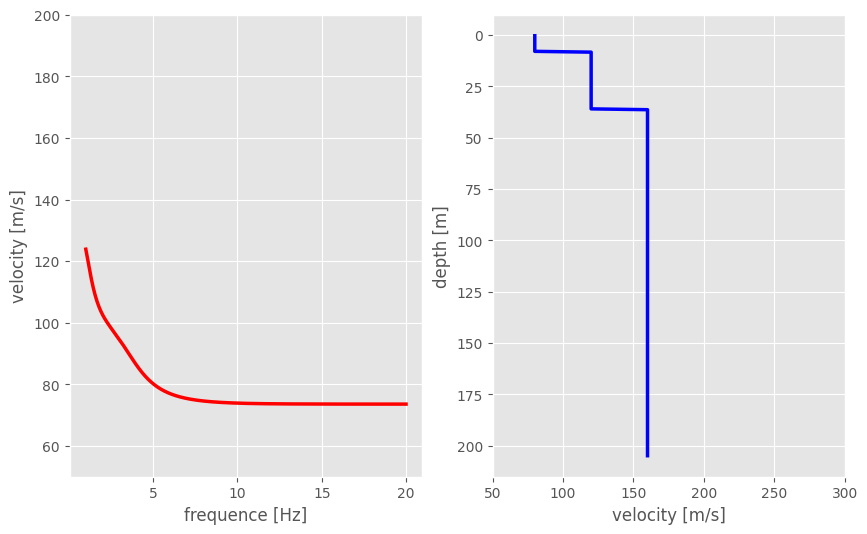

In [5]:
%matplotlib inline
i = 3

cv      = disp[i] * 1000
vs1      = Vs[i] * 1000

with plt.style.context(['ggplot']):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax1.plot(fks, cv, color='red', label='True', linewidth=2.5)
    ax1.set_ylim([50, 200])
    ax1.set_xlabel('frequence [Hz]')
    ax1.set_ylabel('velocity [m/s]')
    ax1.grid(True)
    ax2 = fig.add_subplot(122)
    ax2.plot(vs1, hzcum, color='blue', label='True', linewidth=2.5)
    ax2.set_xlim([50, 300])
    # ax.set_ylim([0, 100])
    ax2.invert_yaxis()
    ax2.set_xlabel('velocity [m/s]')
    ax2.set_ylabel('depth [m]')
    ax2.grid(True)
    

In [6]:
X_train = tf.expand_dims(X_train, axis=2)
y_train = tf.expand_dims(y_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)
y_valid = tf.expand_dims(y_valid, axis=2)
X_test = tf.expand_dims(X_test, axis=2)
y_test = tf.expand_dims(y_test, axis=2)


X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

(TensorShape([768, 512, 1, 1]),
 TensorShape([768, 512, 1, 1]),
 TensorShape([240, 512, 1, 1]),
 TensorShape([240, 512, 1, 1]),
 TensorShape([192, 512, 1, 1]),
 TensorShape([192, 512, 1, 1]))

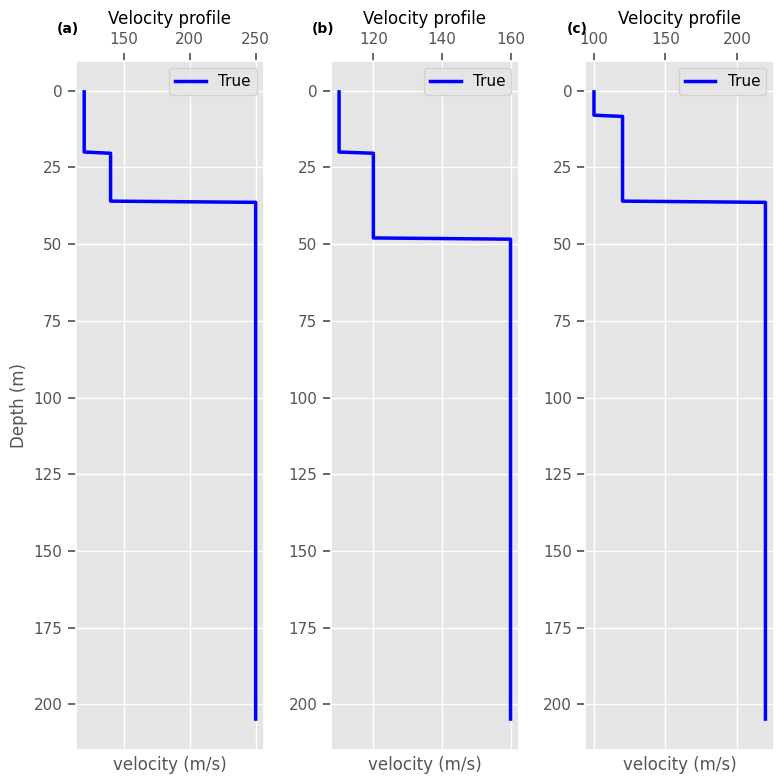

In [7]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)

        ax.plot(np.squeeze(y_test[i, ...])*1000, hzcum, color='blue', label='True', linewidth=2.5)
        ax.set_title('Velocity profile')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

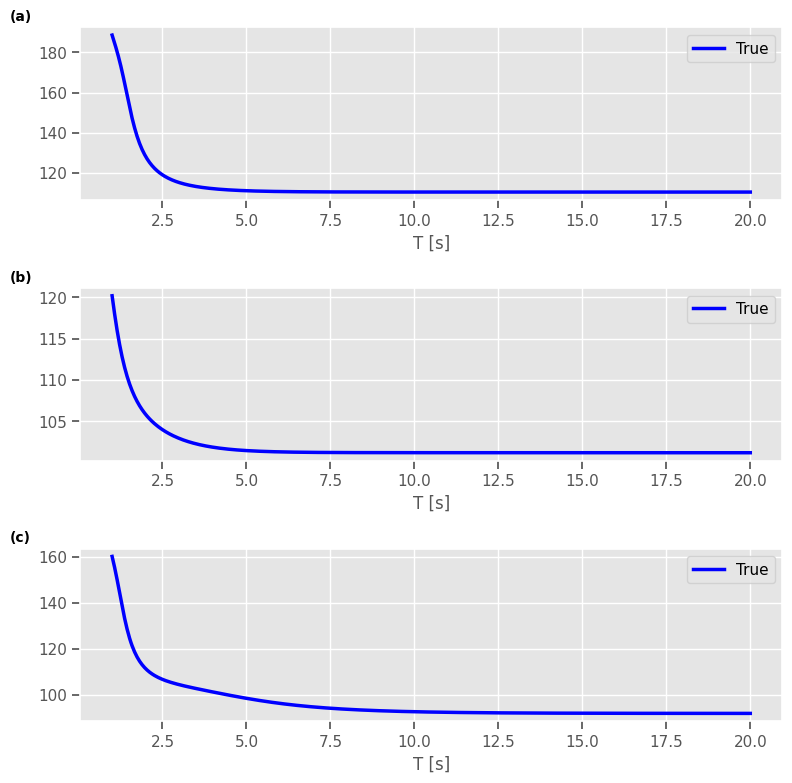

In [8]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)

        ax.plot(fks, np.squeeze(X_test[i, ...])*1000, color='blue', label='True', linewidth=2.5)

        ax.set_xlabel('T [s]')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')

    fig.tight_layout()
    plt.show()

In [9]:
model = GPRNet(im_width=1, im_height=512, neurons=8, kern_sz=10,enable_dropout=False)
# model.summary()
# model.load_weights('checkpoints/all_34/Weights/00540.keras')
# model_depth.load_weights('checkpoints/all_34/Weights/disp_depth_00540.keras')

In [10]:
name_checkpoint = 'checkpoints/2023_10_04/Weights/{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/2023_10_04/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/2023_10_04/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 1000
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=10*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit(X_train, y_train,
          validation_data=[X_valid,y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

Epoch 1/1000
24/24 [==============================] - 6s 40ms/step - loss: 0.0134 - mae: 0.0968 - mse: 0.0134 - R2_score: -5.9946 - val_loss: 0.0024 - val_mae: 0.0390 - val_mse: 0.0024 - val_R2_score: -0.2214 - lr: 1.0000e-04
Epoch 2/1000
24/24 [==============================] - 1s 22ms/step - loss: 0.0022 - mae: 0.0373 - mse: 0.0022 - R2_score: -0.1143 - val_loss: 0.0016 - val_mae: 0.0321 - val_mse: 0.0016 - val_R2_score: 0.1598 - lr: 1.0000e-04
Epoch 3/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.0016 - mae: 0.0318 - mse: 0.0016 - R2_score: 0.1953 - val_loss: 0.0014 - val_mae: 0.0300 - val_mse: 0.0014 - val_R2_score: 0.2595 - lr: 1.0000e-04
Epoch 4/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.0014 - mae: 0.0306 - mse: 0.0014 - R2_score: 0.2705 - val_loss: 0.0013 - val_mae: 0.0290 - val_mse: 0.0013 - val_R2_score: 0.3183 - lr: 1.0000e-04
Epoch 5/1000
24/24 [==============================] - 1s 24ms/step - loss: 0.0014 - mae: 0.0300 - mse

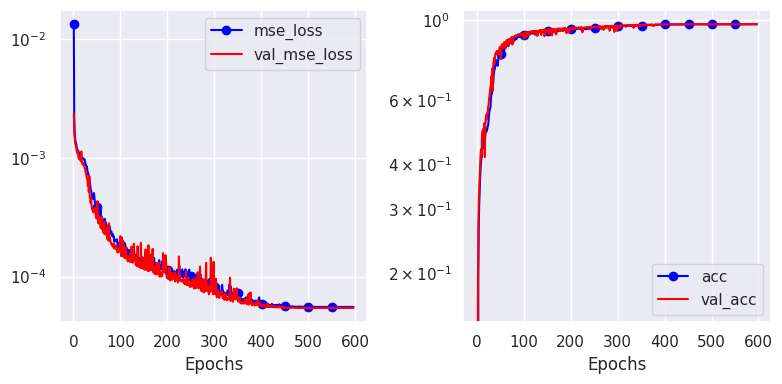

In [11]:
training_log = pd.read_csv('checkpoints/2023_10_04/Logs/disp.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

value = [mse_loss, val_mse_loss, acc, val_acc]
name = ['mse_loss', 'val_mse_loss', 'acc', 'val_acc']

epochs = range(1, len(acc) + 1)

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for i, ax in enumerate(axes):

        ax.plot(epochs, value[2*i], label=name[2*i], marker='o', color='blue', markevery=50)
        ax.plot(epochs, value[2*i+1], label=name[2*i+1], color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.legend()
        #ax.set_title(name)
    
    plt.tight_layout()

plt.show()
    

In [12]:
ypred = model.predict(X_test[:100, ...])

#ypred = model.predict(X_train)

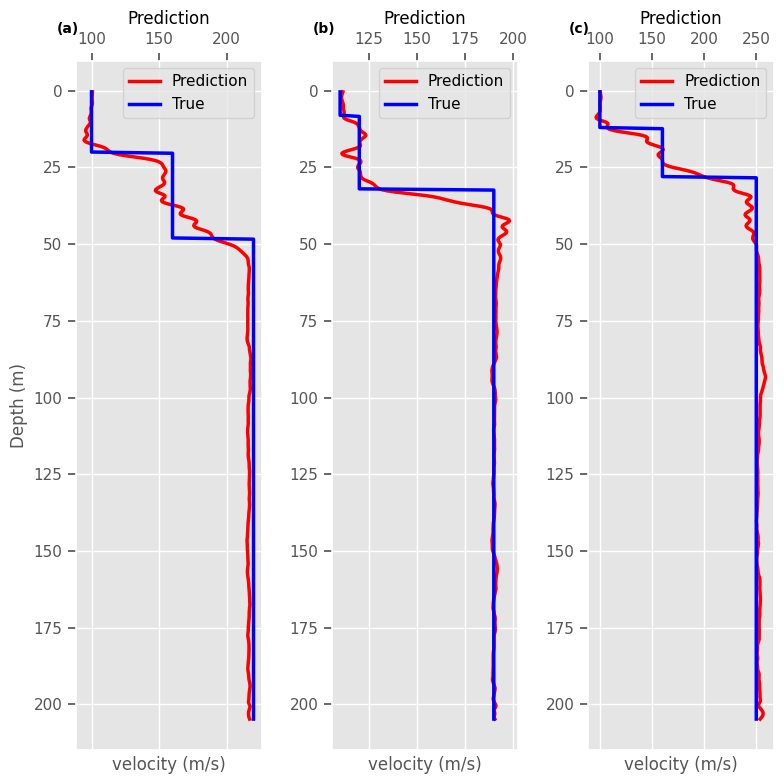

In [13]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)

        yy = smooth(np.squeeze(ypred[i, ...]), window_len=10, window='blackman')
        depth = np.linspace(hzcum.min(), hzcum.max(), len(yy))

        ax.plot(yy*1000, depth, color='red', label='Prediction', linewidth=2.5)
        ax.plot(np.squeeze(y_test[i, ...])*1000, hzcum, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

In [ ]:
yy_im = []
y_im = []

for j in range(100):
    # i = np.random.randint(0, 240)
    if j < 20:
        i = 20
    elif j < 40:
        i = 21
    elif j < 60:
        i = 22
    elif j < 80:
        i = 23
    else:
        i = 24
    ypred = model.predict(X_test[i:i+1, ...])
    yy = smooth(np.squeeze(ypred), window_len=15, window='blackman')
    depth = np.linspace(hzcum.min(), hzcum.max(), len(yy))
    yy_im.append(yy*1000)
    y_im.append(np.squeeze(y_test[i, ...])*1000)

yy_im = np.array(yy_im)
y_im = np.array(y_im)
print(yy_im.shape, y_im.shape)


(100, 531)
(100, 512)

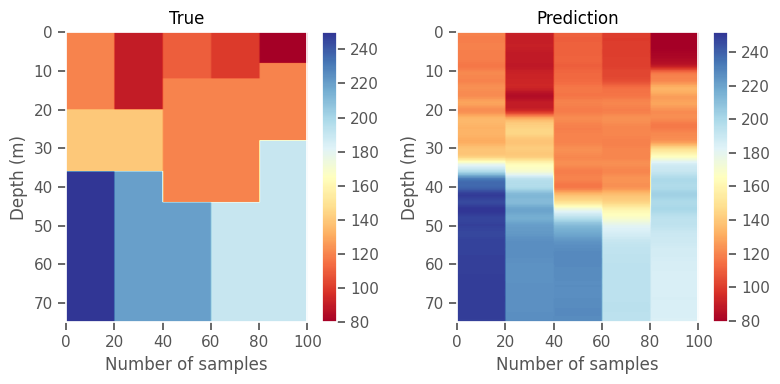

In [24]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(y_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[0].set_xlabel('Number of samples')
    axes[0].set_ylabel('Depth (m)')
    axes[0].set_title('True')
    axes[0].set_ylim([75, 0])
    axes[0].grid(False)
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(yy_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[1].set_xlabel('Number of samples')
    axes[1].set_ylabel('Depth (m)')
    axes[1].set_title('Prediction')
    axes[1].set_ylim([75, 0])
    axes[1].grid(False)
    plt.colorbar(im1, ax=axes[1])
    plt.tight_layout()

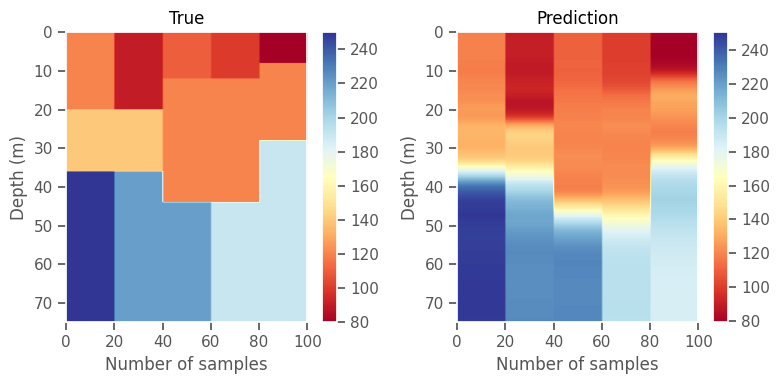

In [26]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(y_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[0].set_xlabel('Number of samples')
    axes[0].set_ylabel('Depth (m)')
    axes[0].set_title('True')
    axes[0].set_ylim([75, 0])
    axes[0].grid(False)
    plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(yy_im.T, cmap='RdYlBu', aspect='auto', extent=[0, 100, hzcum.max(), 0])
    axes[1].set_xlabel('Number of samples')
    axes[1].set_ylabel('Depth (m)')
    axes[1].set_title('Prediction')
    axes[1].set_ylim([75, 0])
    axes[1].grid(False)
    plt.colorbar(im1, ax=axes[1])
    plt.tight_layout()